In [ ]:
"""
 - create binary tree/grid
 - make laplacian
 - solve = Tutte
 - eigenvalues = Spectral
 - gradient descent for eades
 - sgd for stress
"""

In [526]:
import numpy as np
import numpy.linalg as lalg
from numpy.random import rand
import math
from s_gd2 import draw_png, layout
from IPython.display import Image

In [512]:
"""
        0
      /   \
    1       2
   / \     / \
  3   4   5   6

children = x*2+1, x*2+2
parent = (x-1)/2
"""
def maketree(depth):
    I = []
    J = []
    def dfs(idx, depth):
        if depth <= 0:
            return
        parent = (idx-1)//2
        I.append(parent)
        J.append(idx)
        I.append(idx)
        J.append(parent)

        dfs(idx*2+1, depth-1)
        dfs(idx*2+2, depth-1)

    # node 0 is root and so has no parent
    dfs(1, depth-1)
    dfs(2, depth-1)
    return I,J

# make btree graph
depth = 5
I,J = maketree(depth)
n = (1<<depth)-1
A = np.zeros((n,n))
for i,j in zip(I,J):
    A[i,j] = 1

In [529]:
"""
   0 - 1 - 2 - 3
   |   |   |   |
   4 - 5 - 6 - 7
   |   |   |   |
   8 - 9 - 10- 11 
   |   |   |   |
   12- 13- 14- 15
"""

def two2oned(row, col):
    return row*width + col

def makegrid(width):
    I = []
    J = []
    for row in range(width):
        for col in range(width):
            if row>0:
                I.append(two2oned(row,col))
                J.append(two2oned(row-1,col))
            if row<width-1:
                I.append(two2oned(row,col))
                J.append(two2oned(row+1,col))
            if col>0:
                I.append(two2oned(row,col))
                J.append(two2oned(row,col-1))
            if col<width-1:
                I.append(two2oned(row,col))
                J.append(two2oned(row,col+1))
    return I,J

#make grid graph
width = 6
I,J = makegrid(width)
n = width*width
A = np.zeros((n,n))
for i,j in zip(I,J):
    A[i,j] = 1

In [532]:
# calculate Laplacian matrix

D = np.identity(n) * np.sum(A, axis=1)
L = D - A

In [533]:
# Tutte tree: fix leaf vertices then solve

firstleaf = (1<<(depth-1))-1
print(f'{depth} {n} {firstleaf}')

b = np.zeros((n,2))
nleaves = (n-firstleaf)
for i in range(firstleaf+1, n):
    L[i,:] = 0
    L[i,i] = 1
    rad = (i-firstleaf)/nleaves * 2*math.pi
    b[i,0] = math.cos(rad)
    b[i,1] = math.sin(rad)
    
X = lalg.solve(L, b)

5 36 15


In [114]:
# Tutte grid: fix boundary vertices then solve
b = np.zeros((n,2))

def setlaplacianzero(idx, x, y):
    L[idx,:] = 0
    L[idx,idx] = 1
    b[idx,0] = x
    b[idx,1] = y
    
# spiral order hehe
for col in range(width):
    setlaplacianzero(two2oned(0,col), col, 0)
for row in range(1,width):
    setlaplacianzero(two2oned(row,width-1), width-1, row)
for col in range(width-2,-1,-1):
    setlaplacianzero(two2oned(width-1,col), col, width-1)
for row in range(width-2,0,-1):
    setlaplacianzero(two2oned(row,0), 0, row)
    
X = lalg.solve(L, b)

In [116]:
# Spectral: calculate eigenvalues

w,v = lalg.eig(L)

# take second and third eigenvectors
idx = w.argsort()
X = np.real(v[:,idx[1:3]]) # 0 index is zero eigenvalue

In [523]:
# Eades
c1 = 2
c2 = 1
c3 = 1
c4 = .1
iters = 200

X = rand(n,2)
for i in range(iters):
    # sum up gradients
    ddx = np.zeros((n,2))
    for src in range(n):
        for tgt in range(n):
            if src==tgt:
                continue
            vec = X[tgt] - X[src]
            mag = lalg.norm(vec)
            norm = vec/mag
            if A[src,tgt] != 0:
                ddx[src] -= c1 * math.log2(mag/c2) * norm
            else:
                ddx[src] += (c3 / (mag*mag)) * norm
    # descend
    for src in range(n):
        X[src] -= c4 * ddx[src]

In [530]:
# stress
X = layout(I,J)

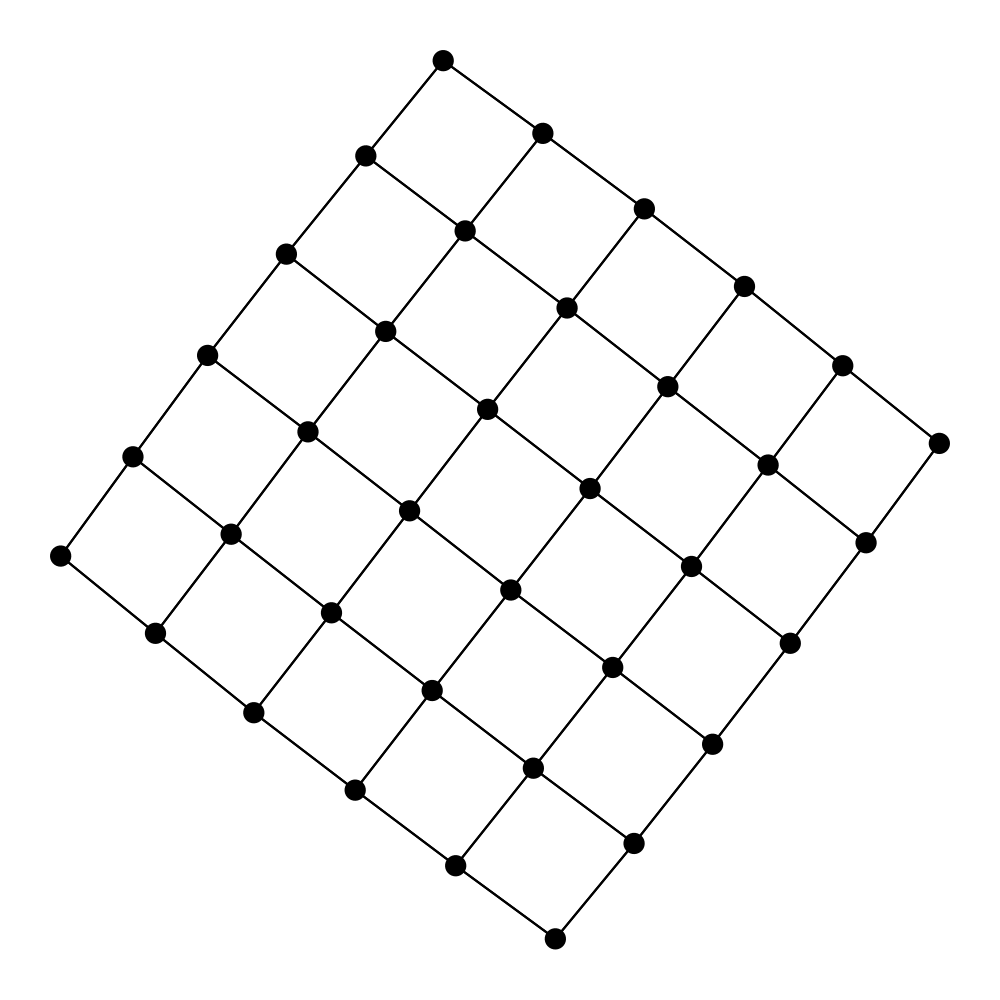

In [531]:
draw_png(X, I, J, 'graph.png', linkwidth=.02, noderadius=.1)
Image(filename='graph.png') 